In [1]:
import pandas as pd
import numpy as np
import datetime

import json
import matplotlib.pyplot as plt

import requests

import asyncio
import websockets
import json
import nest_asyncio
nest_asyncio.apply()


def GrabDateFromName(instrumentname):
    if pd.isnull(instrumentname):
        return ("","","","","","")

    instrumentname2 = instrumentname[4:]
    
    posfinder = instrumentname2.find("-")
    if posfinder == -1:
        contractdate = instrumentname2
        if instrumentname2 =="SPOT":
            expirydate = 0
        elif instrumentname2 =="PERPETUAL":
            expirydate = datetime.datetime.today()
        else:
            expirydate = datetime.datetime.strptime(instrumentname2,"%d%b%y")
    if posfinder > -1:
        contractdate = instrumentname2[0:posfinder]
        expirydate = datetime.datetime.strptime(instrumentname2[0:posfinder],"%d%b%y")

    return (contractdate, expirydate)

def DBDataGrabber(method, params):
    # method = Deribit function
    # params = params in dictionary format
    msg = {"method": method, "params": params}
    webdata = requests.get("https://test.deribit.com/api/v2/public/"+method,params)
    return webdata.json()

futureslist = ['BTC-25MAR22', 'BTC-28JAN22', 'BTC-24JUN22', 'BTC-30SEP22', 'BTC-31DEC21', 'BTC-PERPETUAL']

channelslist = ['ticker.BTC-25MAR22.100ms', 'ticker.BTC-28JAN22.100ms', 'ticker.BTC-24JUN22.100ms', 'ticker.BTC-30SEP22.100ms', 'ticker.BTC-31DEC21.100ms', 'ticker.BTC-PERPETUAL.100ms']

msg = {"jsonrpc": "2.0",
     "method": "public/subscribe",
     "id": 42,
     "params": {
        "channels": channelslist}
    }


Successfully subscribed


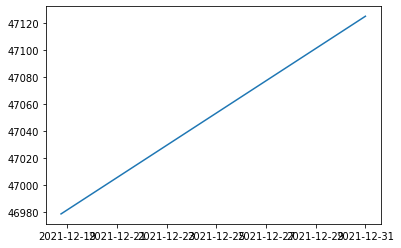

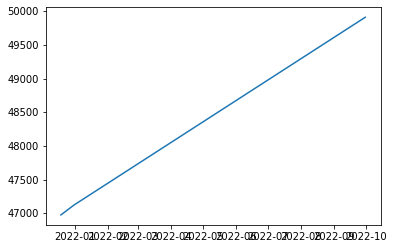

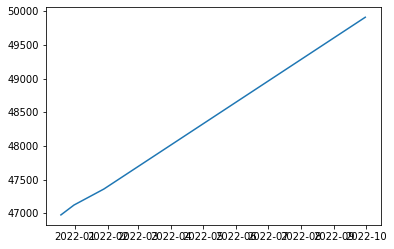

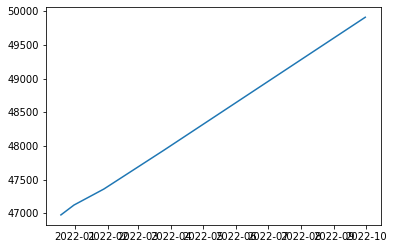

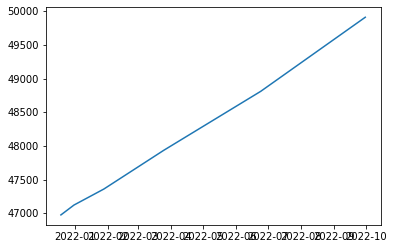

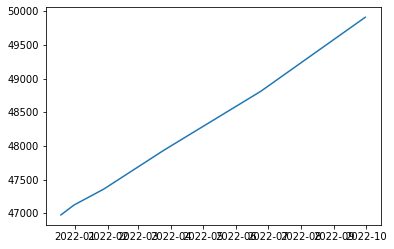

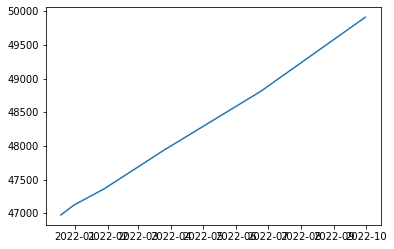

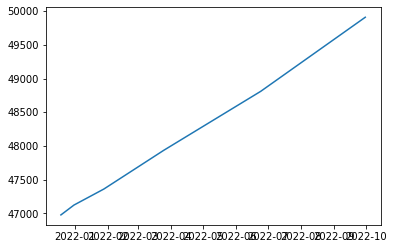

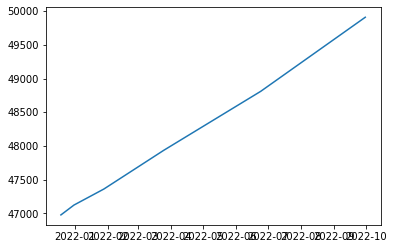

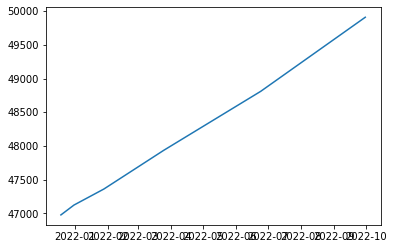

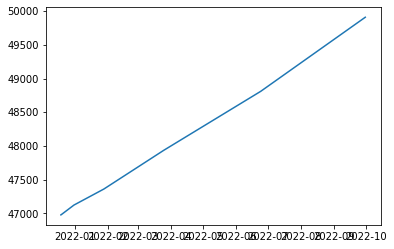

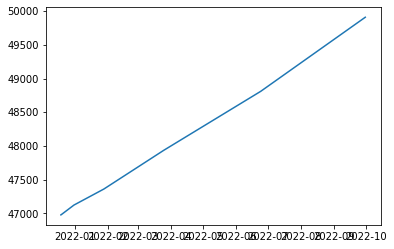

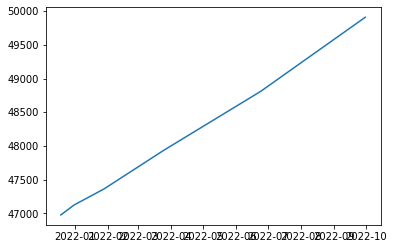

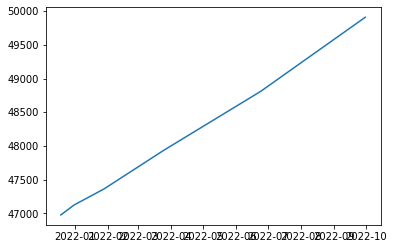

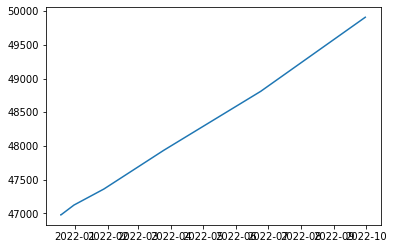

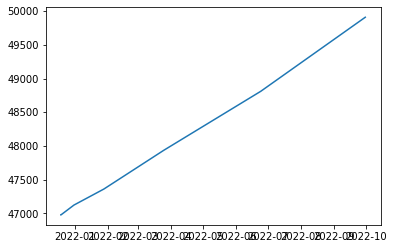

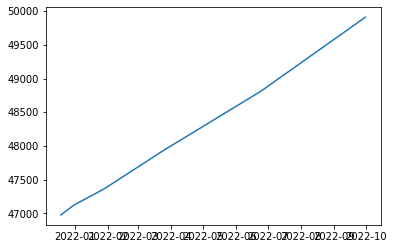

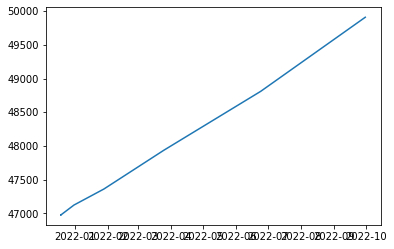

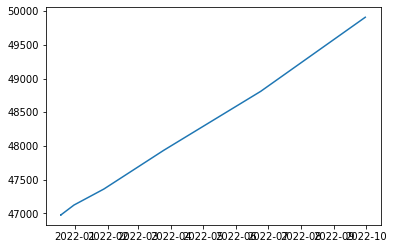

In [2]:

futuresprices = {}
async def call_api(msg):
    async with websockets.connect('wss://test.deribit.com/ws/api/v2') as websocket:
        await websocket.send(msg)
        n=0
        while websocket.open:
            response = await websocket.recv()
            output1 = json.loads(response)
            if "result" in output1.keys():
                print("Successfully subscribed")
            if "result" not in output1.keys():
                if output1["params"]["channel"] in channelslist:
                    contractdate = GrabDateFromName(output1["params"]["channel"][7:-6])[1]
                    markprice = output1["params"]["data"]["mark_price"]
                    futuresprices[contractdate] = markprice
            
            n=n+1
            if n>2:
                futurespricetable = pd.DataFrame.from_dict(futuresprices, orient="index").sort_index()
                plt.plot(futurespricetable)
                plt.show()
            # This bit stops the code after awhile, while we are in test mode
            if n>20:
                break

asyncio.get_event_loop().run_until_complete(call_api(json.dumps(msg)))


In [3]:
def GrabOIData():
    OIList = {}
    for eachfut in futureslist:
        OIList[eachfut] = DBDataGrabber("ticker",{"instrument_name": eachfut})["result"]["open_interest"]
    display(OIList)
GrabOIData()   

{'BTC-25MAR22': 447906040,
 'BTC-28JAN22': 17545390,
 'BTC-24JUN22': 210076990,
 'BTC-30SEP22': 32830010,
 'BTC-31DEC21': 936737390,
 'BTC-PERPETUAL': 3311781500}